**Universidad de los Andes**<br>
Facultad de Ingeniería<br>
__Maestría en Inteligencia Artificial__

# Alcanzando los objetivos de desarrollo sostenible.

Autores: __Andrés Vega__ y __David Méndez Acuña__

### Introducción

In [10]:
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud

# Si el paso de bag of words falla, descomentar 
# las lineas de abajo, ejecutar y volver a comentar

# import nltk
# nltk.download('stopwords')

In [11]:
class Context:
    '''
    Clase que permite almacenar el contexto de ejecución de los pasos 
    del pipeline. Esta clase será particularmente útil en el último 
    paso del pipeline donde necesitaremoslos datos generados por todos 
    los pasos del pipeline para imprimir el detalle de los resultados.
    '''
    def __init__(self) -> None:
        self.x_train = None
        self.y_train = None
        self.model = None
        self.mode = 'training'

    def log(message=None):
        '''
        Imprime el mensaje que entra por parámetro acompañado de la hora 
        actual. Este método será util para la trazabilidad de la ejecución
        del pipeline.  
        '''
        now = datetime.now()
        print(f'[INFO] {now.strftime("%H:%M:%S")} — {message}')

In [12]:
class Preprocess(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de hacer un pre-procesamiento de los datos de entrada.
    En particular, se dividen los datos de entrada en dos conjuntos: el primero reservado para
    el entrenamiento, el segundo para las pruebas. También se separan los textos de las etiquetas
    y se aplican los pasos de tokenización, steaming. Finalmente se eliminan las palabras vacías.   
    '''
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe los datos de entrada en una representación tabular y aplica los pasos de tokenización,
        steaming y supresión de palabras vacías.  
        
        Parámetros relevantes
        ------------------------
        X : pandas.DataFrame
            La ruta del archivo que contiene los datos de entrada. 

        Retornos
        ------------------------
        processed : pandas.DataFrame
            Los datos de entrada procesados en un data frame. 

        '''
        Context.log(message='PASO 2: Pre-procesamiento de textos | Inicio de la ejecución')
        
        # Separamos los datos de las etiquetas y dividimos los datos en dos conjuntos, 
        # el primero para el entrenamiento y el segundo para las pruebas. 
        if self.context.mode != 'predict' :
            x_train = X["textos"]
            y_train = X["ODS"]
            x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=42, train_size=0.8)
            self.context.x_test = x_test
            self.context.y_test = y_test
        else :
            x_train = X.serie_prueba["textos"]
            y_train = None
            
        self.context.x_train = x_train
        self.context.y_train = y_train

        # Tokenización de los datos de entrenamiento 
        tokenized = x_train.apply(lambda x: word_tokenize(x))
        self.context.tokenized = tokenized

        tokenizer = RegexpTokenizer(r'\w+')
        tokenized_no_punct = x_train.apply(lambda x: tokenizer.tokenize(x))
        self.context.tokenized_no_punct = tokenized_no_punct

        # Removemos las palabras vacías
        nltk_stopwords = stopwords.words("spanish")
        no_stopwords = tokenized_no_punct.apply(lambda x: [token for token in x if token not in nltk_stopwords])
        self.context.no_stopwords = no_stopwords

        stemmer = PorterStemmer()
        stemmed = no_stopwords.apply(lambda x: [stemmer.stem(token) for token in x])
        processed = stemmed.apply(lambda x: ' '.join(x))
        self.context.processed = processed

        Context.log(message='PASO 2: Pre-procesamiento de textos | Fin de la ejecución')

        return x_train, y_train
    

In [13]:
class BagOfWords(BaseEstimator, TransformerMixin) :
    '''
    Este paseo del pipeline se encarga de transformar los datos de entrenamiento
    en una representación vectorial conforme a una bolsa de palabras. 

    '''
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe los datos de entrenamiento en una representación tabular y los retorna
        en forma de bolsa de palabras. 
        
        Parámetros relevantes
        ------------------------
        X : pandas.DataFrame
            Los datos de entrenamiento organizados de manera tabular en un data frame. 

        Retornos
        ------------------------
        bow : scipy.sparse._csr.csr_matrix
            ...
        '''
        Context.log(message='PASO 3: Generación de la bolsa de palabras | Inicio de la ejecución')
        
        # Construimos la bolsa de palabras
        vectorizer = CountVectorizer()
        bow = vectorizer.fit_transform(self.context.processed)
        self.context.bow = bow

        Context.log(message='PASO 3: Generación de la bolsa de palabras | Fin de la ejecución')
        return X, y
    

In [14]:
class PredictiveModel(BaseEstimator, TransformerMixin) :
     
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :
        return self
        
    def transform(self, X, y=None) :
        

        if self.context.mode != 'predict' :
            Context.log(message='PASO 4: Reducción de la dimensionalidad | Inicio de la ejecución')
            tsvd = TruncatedSVD(n_components=100)
            reduced_bow = tsvd.fit_transform(self.context.bow)
            Context.log(message='PASO 4: Reducción de la dimensionalidad | Fin de la ejecución')

            Context.log(message='PASO 5: Entrenamiento | Inicio de la ejecución')
            logreg = LogisticRegression(max_iter=500)
            logreg.fit(reduced_bow, self.context.y_train)
            self.context.model = logreg
            
            Context.log(message='PASO 5: Entrenamiento | Fin de la ejecución')
        return X, y
        

In [15]:
class PretryPrinter(BaseEstimator, TransformerMixin) :
     
    def __init__(self, context) -> None :
        self.context = context

    def fit(self, X, y=None) :
        if(self.context.mode != 'predict') :
            wc_text = ' '.join(word for text in self.context.no_stopwords for word in text)

            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color ='white',
                min_font_size=10,
                max_font_size=110
            ).generate(wc_text)
            
            plt.figure(figsize=(10, 10))
            plt.imshow(wordcloud)
            plt.axis('off')
            plt.show()
        return self
    
    def transform(self, X, y=None) :
         pass
    
    def predict(self, X, y=None) :
        display(X)
        display(self.context.serie_prueba)
        return self.context.model.predict(self.context.serie_prueba)

[INFO] 22:15:31 — PASO 2: Pre-procesamiento de textos | Inicio de la ejecución
[INFO] 22:15:37 — PASO 2: Pre-procesamiento de textos | Fin de la ejecución
[INFO] 22:15:38 — PASO 3: Generación de la bolsa de palabras | Inicio de la ejecución
[INFO] 22:15:38 — PASO 3: Generación de la bolsa de palabras | Fin de la ejecución
[INFO] 22:15:38 — PASO 4: Reducción de la dimensionalidad | Inicio de la ejecución
[INFO] 22:15:39 — PASO 4: Reducción de la dimensionalidad | Fin de la ejecución
[INFO] 22:15:39 — PASO 5: Entrenamiento | Inicio de la ejecución
[INFO] 22:15:40 — PASO 5: Entrenamiento | Fin de la ejecución


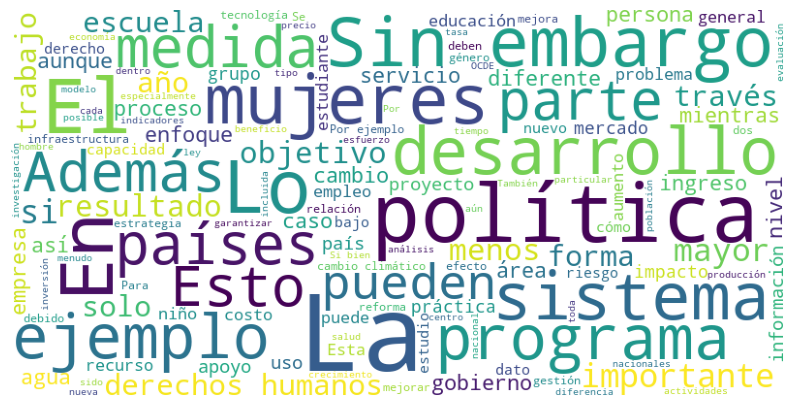

Pipeline(steps=[('pre-processing',
                 Preprocess(context=<__main__.Context object at 0x168853790>)),
                ('bow',
                 BagOfWords(context=<__main__.Context object at 0x168853790>)),
                ('model',
                 PredictiveModel(context=<__main__.Context object at 0x168853790>)),
                ('prettyPrinter',
                 PretryPrinter(context=<__main__.Context object at 0x168853790>))])

In [16]:
context = Context()

data_raw = pd.read_excel('./data/textos.xlsx')

steps = [
    ("pre-processing", Preprocess(context)),
    ("bow", BagOfWords(context)),
    ("model", PredictiveModel(context)),
    ("prettyPrinter", PretryPrinter(context))
]
pipeline = Pipeline(steps)
pipeline.fit(data_raw)

In [17]:
ods = pd.DataFrame(data=['No poverty', 'Zero hunger', 'Good health and well-being', 'Quality education', 'Gender equality', 'Clean water and sanitation',
                         'Affordable and clean energy', 'Decent work and economic growth', 'Industry, innovation, and infrastructure', 'Reduced inequalities',
                         'Sustainable cities and communities', 'Reponsible consumption and production','Climate action', 'Life below water', 'Life an land', 'Peace, justice and strong institutions',
                         'Partnerships for the goals'])

def predecir(context=None, texto=None):
    context.mode = 'predict'
    serie_prueba = pd.DataFrame(data=[texto], columns=["textos"])
    prediccion_prueba = pipeline.predict(context)
    #resultado = ods.iloc[prediccion_prueba[0]-1,0]
    return prediccion_prueba

In [18]:
prueba = 'Garantizar acceso al agua potable a la población vulnerable en los barrios del sur de Bogotá'
predecir(context=context, texto=prueba)

[INFO] 22:15:42 — PASO 2: Pre-procesamiento de textos | Inicio de la ejecución
[INFO] 22:15:42 — PASO 2: Pre-procesamiento de textos | Fin de la ejecución
[INFO] 22:15:42 — PASO 3: Generación de la bolsa de palabras | Inicio de la ejecución
[INFO] 22:15:42 — PASO 3: Generación de la bolsa de palabras | Fin de la ejecución


(((0    Garantizar acceso al agua potable a la poblaci...
   Name: textos, dtype: object,
   None),
  None),
 None)

,textos
0,Garantizar acceso al agua potable a la poblaci...


/Users/damenac/workspaces/maia/.venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'Garantizar acceso al agua potable a la población vulnerable en los barrios del sur de Bogotá'